## Generative Adversarial Networks (GANs)

План на сегодня: реализуем генерацию лиц с обучением генеративной состязательной сети (GAN)

Для самостоятельных упражнений вы можете выбрать любой из датасетов:
- CelebA: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
- PeopleArt: https://www.kaggle.com/datasets/amanagr/people-art-dataset
- Best Artworks of All Time: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time
- Cartoon Faces (Google's Cartoon Set): https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set

### Подготовим данные

In [1]:
from pathlib import Path
from typing import Callable, cast

import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
class ImageDataset(Dataset):
    def __init__(
        self,
        datadir: Path,
        transform: Callable[[Image.Image], Tensor],
        pattern: str = "*.jpg",
    ) -> None:
        self.images = list(datadir.rglob(pattern))
        self.transform = transform

    def __getitem__(self, index) -> Tensor:
        img = Image.open(self.images[index])
        return self.transform(img)

    def __len__(self) -> int:
        return len(self.images)

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

In [ ]:
# если работаете локально или в Google Colab, укажите правильный путь до папки с изображениями
datadir = Path("/kaggle/input/celeba-dataset/img_align_celeba")
dataset = ImageDataset(
    datadir,
    transform=transform,
)
print(len(dataset))
print(dataset[0].shape)

202599
torch.Size([3, 64, 64])


In [5]:
loader = DataLoader(dataset, batch_size=16, shuffle=True)

batch = next(iter(loader))
print(batch.shape)

torch.Size([16, 3, 64, 64])


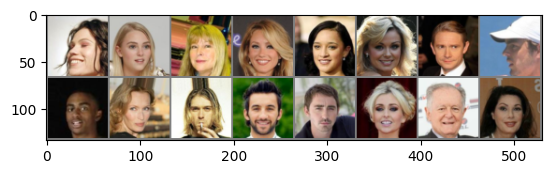

In [6]:
img_grid = torchvision.utils.make_grid(
    tensor=batch,
    nrow=8,
    padding=2,
    normalize=False,
)

plt.imshow(
    torchvision.transforms.ToPILImage()(
        img_grid * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
        + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    )
)

### Обучение GAN

Генеративная состязательная сеть — не одна модель, а скорее парадигма обучения, в которой используются две модели:
1. Генератор: генерирует новые примеры данных, пытаясь обмануть дискриминатор
2. Дискриминатор: классифицирует наблюдения на реальные и созданные генератором

Ошибка дискриминатора: $E_{x \sim p_{data}(x)}[\log D(x)] + E_{x \sim p_{g}(x)}[\log (1 - D(x))]$

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram_discriminator.svg" style="background:white" width="700"/>

Ошибка генератора: $- E_{z \sim p_z(z)}[\log D(G(z))]$

<img src="https://developers.google.com/static/machine-learning/gan/images/gan_diagram_generator.svg" style="background:white" width="700"/>

Обучение GAN — то ещё приключение, есть несколько трюков, которые более-менее работают: https://github.com/soumith/ganhacks

In [ ]:
class GAN(L.LightningModule):
    def __init__(
        self,
        generator: nn.Module,
        discriminator: nn.Module,
        discriminator_period: int = 5,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.discriminator_period = discriminator_period

        # NB: у нас 2 оптимизатора, поэтому обновлять параметры будем вручную
        self.automatic_optimization = False

    def generate(self, n: int) -> Tensor:
        # Генерируем n изображений из случайного шума
        device = next(self.generator.parameters()).device
        latent_size, *_ = next(self.generator.parameters()).data.shape
        z = torch.randn(n, latent_size, 1, 1, device=device)
        return self.generator(z)

    def training_step(self, batch: Tensor, batch_idx: int) -> None:
        # Шаг генератора
        self.generator_step(batch)

        # Шаг дискриминатора
        if batch_idx % self.discriminator_period == 0:
            self.discriminator_step(batch)

    def configure_optimizers(self):
        # наши 2 оптимизатора: один для параметров генератора, другой — для параметров дискриминатора
        gen_opt = torch.optim.Adam(
            self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999)
        )
        dis_opt = torch.optim.Adam(
            self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
        )
        return [gen_opt, dis_opt]

    def generator_step(self, batch: Tensor) -> None:
        optimizer_g, _ = self.optimizers(use_pl_optimizer=True)

        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_g`
        self.toggle_optimizer(optimizer_g)

        # Генерируем батч изображений
        fake = ...

        # Получаем оценку дискриминатора для `fake`
        fake_scores = ...
        # Считаем ошибку генератора
        g_loss = ...

        # Обновляем параметры генератора
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()

        # Восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)
        self.untoggle_optimizer(optimizer_g)

        self.log("g_loss", g_loss, prog_bar=True)

    def discriminator_step(self, batch: Tensor) -> None:
        _, optimizer_d = self.optimizers(use_pl_optimizer=True)

        # Отключаем расчёт градиентов для параметров, которые не относятся к `optimizer_d`
        self.toggle_optimizer(optimizer_d)

        # Считаем ошибку дискриминатора на реальных изображениях
        real_scores = ...
        real_loss = ...

        # Считаем ошибку дискриминатора на сгенерированных изображениях
        fake = ...
        fake_scores = ...
        fake_loss = ...

        # Обновляем параметры дискриминатора
        d_loss = 0.5 * (real_loss + fake_loss)
        self.manual_backward(d_loss)
        optimizer_d.step()
        optimizer_d.zero_grad()

        # восстанавливаем состояние параметров (обратное действие к `toggle_optimizer`)
        self.untoggle_optimizer(optimizer_d)

        self.log("real_loss", real_loss, prog_bar=True)
        self.log("fake_loss", fake_loss, prog_bar=True)

    def on_train_epoch_end(self) -> None:
        images = self.generate(16)
        grid = torchvision.utils.make_grid(
            tensor=images,
            nrow=8,
            padding=2,
            normalize=True,
            value_range=(-1, 1),
        )
        str_title = f"{self.__class__.__name__}_images"
        logger = cast(TensorBoardLogger, self.logger)
        logger.experiment.add_image(str_title, grid, global_step=self.global_step)

#### Простые архитектуры генератора и дискриминатора

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_size: int):
        super().__init__()
        self.latent_size = latent_size

        self.conv1 = nn.ConvTranspose2d(latent_size, 64 * 8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 8)
        self.conv2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv3 = nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 2)
        self.conv4 = nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * 2)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64 * 4)
        self.conv4 = nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64 * 8)
        self.conv5 = nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        x = self.conv5(x).view(-1, 1)
        return x

In [ ]:
generator = Generator(latent_size=256)
discriminator = Discriminator()

trainer = L.Trainer(
    max_epochs=50,
    logger=TensorBoardLogger(save_dir="logs", name="gan"),
    limit_train_batches=1000,
)

lit = GAN(generator, discriminator, discriminator_period=3)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [ ]:
trainer.fit(model=lit, train_dataloaders=loader)

Подгружаем лучшие веса и наслаждаемся:

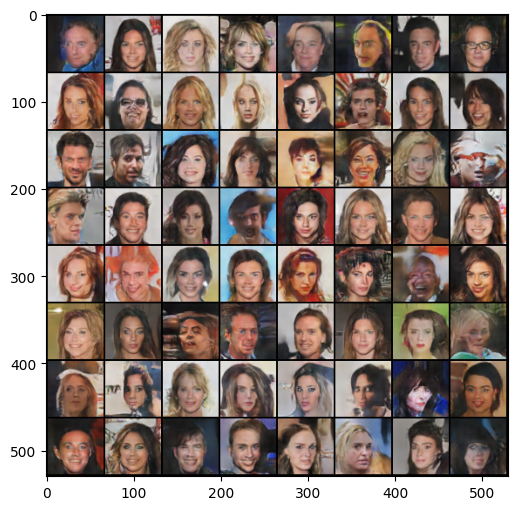

In [ ]:
model_version = "version_0"
checkpoint_path = next(Path(f"logs/gan/{model_version}/checkpoints/").glob("*.ckpt"))
lit = GAN(generator, discriminator, discriminator_period=3)
lit.load_state_dict(torch.load(checkpoint_path, weights_only=True)["state_dict"])
images = lit.generate(n=64)
grid = torchvision.utils.make_grid(
    tensor=images,
    nrow=8,
    padding=2,
    normalize=True,
    value_range=(-1, 1),
)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(torchvision.transforms.ToPILImage()(grid))

### Упражнения

1. Реализуйте обучение LSGAN (https://paperswithcode.com/method/lsgan)
2. Реализуйте обучение Wasserstein GAN + Gradient penalty (https://paperswithcode.com/method/wgan-gp)